# A method to correct precipitation fields for ocean models.

*R. Dussin*

## 1. Regridding GPCP v2.3 to ERAinterim grid

The first step is to regrid the satelite-based precipitations onto the Atmospheric reanalyse grid. This can be done easily with xesmf. I'm testing with bilinear but I might want to change to conservative regridding once I have the grid corners in.

In [115]:
gpcpdir = '/Users/raphael/STORAGE/GPCP2.3/'
gpcp = xr.open_dataset(gpcpdir + 'precip.mon.mean.nc')

In [116]:
gpcp

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 482)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-02-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes:
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    documentation:  

In [118]:
import xesmf

We need the ERAinterim grid, I use the one that's not upside down:

In [120]:
era_grid = xr.open_dataset('/Users/raphael/TOOLS/interimR/data/masks/lsm_ERAinterim_roms.nc')

In [122]:
era_grid

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512)
Coordinates:
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
Data variables:
    lsm      (lat, lon) int32 ...
Attributes:
    description:  ERAinterim post-processing (raphael.dussin@gmail.com)

In [123]:
gpcp2erai = xesmf.Regridder(gpcp, era_grid, 'bilinear', periodic=True)

Create weight file: bilinear_72x144_256x512_peri.nc


In [125]:
gpcp_precip_interp = gpcp2erai(gpcp['precip'])

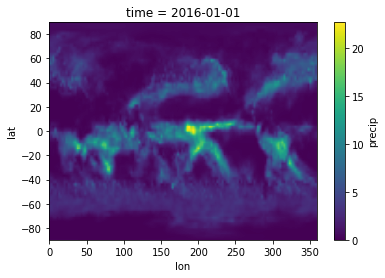

In [127]:
gpcp_precip_interp.sel(time='2016-1').plot()

In [128]:
gpcp_precip_interp

<xarray.DataArray 'precip' (time: 482, lat: 256, lon: 512)>
array([[[5.320854e-03, 5.321156e-03, ..., 5.321585e-03, 5.321156e-03],
        [1.243755e-04, 1.250687e-04, ..., 1.260528e-04, 1.250687e-04],
        ...,
        [6.814923e-01, 6.686581e-01, ..., 6.979605e-01, 6.942922e-01],
        [5.528836e-01, 5.472924e-01, ..., 5.600580e-01, 5.584600e-01]],

       [[3.718624e-01, 3.759139e-01, ..., 3.644828e-01, 3.678168e-01],
        [3.210450e-01, 3.303448e-01, ..., 3.041058e-01, 3.117587e-01],
        ...,
        [8.382110e-01, 8.457530e-01, ..., 8.267824e-01, 8.306756e-01],
        [8.629789e-01, 8.662646e-01, ..., 8.580000e-01, 8.596960e-01]],

       ...,

       [[7.244400e-02, 7.243282e-02, ..., 7.242311e-02, 7.245235e-02],
        [9.687844e-02, 9.685276e-02, ..., 9.683048e-02, 9.689760e-02],
        ...,
        [7.895018e-02, 7.902509e-02, ..., 7.882547e-02, 7.887601e-02],
        [8.175147e-02, 8.178411e-02, ..., 8.169714e-02, 8.171916e-02]],

       [[4.064845e-03, 4.06494

## functions

In [14]:
import xarray as xr
import numpy as np
import pandas as pd

In [27]:
%matplotlib inline

In [102]:
def cumul_precip(da):
    ''' apply cumsum and scale data array'''
    # create cumulated precip
    da_cs = da.cumsum(dim='time')
    # concat with zero initial value, needed for decumul
    zeroslice = xr.zeros_like(da_cs.isel(time=0))
    da_cs = xr.concat([zeroslice, da_cs], dim='time')
    return da_cs

def normalize_cumulated_precip(da):
    # normalize to the last value
    print(da.isel(time=-1).min())
    norm = da.isel(time=-1).clip(min=1e-15)
    print(norm.min().values)
    da_scaled = da / norm
    return da_scaled

In [71]:
def decumul_precip(da):
    out = da.diff('time')
    return out

## Method

* extract monthly data from ERAinterim yearly file
* cumul/scale the data and reserve
* conservative regridding of monthly GPCP onto ERAinterim grid
* total precip in GPCP = avg monthly value * ndays_in_month
* rescale the cumulative sum with GPCP value (smoothing required?)
* run decumulation

## Test on one file

In [7]:
precip_era = xr.open_dataset('/Users/raphael/STORAGE/ERAinterim/nc_processed_nemo/precip_ERAinterim_2016_daily.nc',
                            decode_times=False)

In [9]:
precip_era.time

<xarray.DataArray 'time' (time: 366)>
array([42368.5, 42369.5, 42370.5, ..., 42731.5, 42732.5, 42733.5])
Coordinates:
  * time     (time) float64 4.237e+04 4.237e+04 ... 4.273e+04 4.273e+04
Attributes:
    units:      days since 1900-01-01T00:00:00
    valid_min:  42368.5
    valid_max:  42733.5
    calendar:   LEAP

In [12]:
precip_era['time'] = pd.date_range(start='2016-1-1', end='2016-12-31')

In [13]:
precip_era.time

<xarray.DataArray 'time' (time: 366)>
array(['2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', ..., '2016-12-29T00:00:00.000000000',
       '2016-12-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-12-31

In [20]:
precip_month = precip_era.sel(time='2016-1')

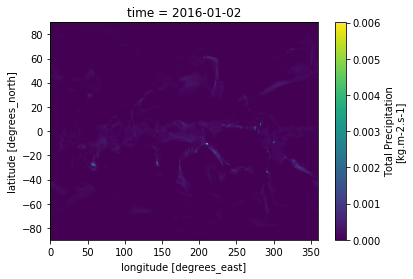

In [56]:
precip_month['precip'].sel(time='2016-1-2').plot()

In [72]:
cumulated = cumul_precip(precip_month['precip'])

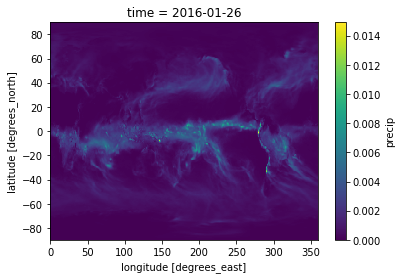

In [73]:
cumulated.sel(time='2016-1-26').plot()

In [103]:
cumulated_norm = normalize_cumulated_precip(cumulated)

<xarray.DataArray 'precip' ()>
array(0., dtype=float32)
Coordinates:
    time     datetime64[ns] 2016-01-31
1e-15


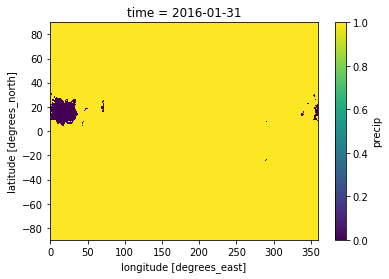

In [105]:
cumulated_norm.isel(time=31).plot()

In [75]:
avg = precip_month.mean(dim='time')

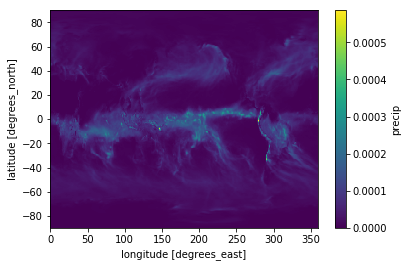

In [76]:
avg['precip'].plot()

In [110]:
back = decumul_precip(cumulated_norm * avg['precip'] * 31)

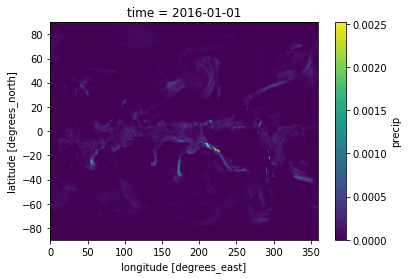

In [111]:
back.sel(time='2016-1-1').plot()

In [112]:
verif = back - precip_month

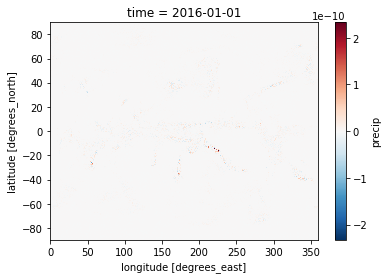

In [114]:
verif['precip'].isel(time=0).plot()